<a href="https://colab.research.google.com/github/stacylmartin1/hello-world/blob/main/birdCLEF2025_paligemma2_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune PaliGemma2 on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

This notebook finetunes Paligemma2 on the BirdCLEF2025 training dataset.

Notebook requires A100 with 40GB of VRAM to train.

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import userdata
import os

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

!pip install -q roboflow supervision peft bitsandbytes transformers==4.47.0

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
version = project.version(4)
dataset = version.download("paligemma")

**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

In [ ]:
!pip install -U librosa

In [ ]:
!pip install -q supervision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import joblib
# import openvino as ov
import librosa
import torch
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Load data


In [ ]:
train_all_df = pd.DataFrame()
train_audio_dir = '/content/drive/MyDrive/kaggle/train_audio/'
kaaggle_root_dir = '/content/drive/MyDrive/kaggle/'
# # test_audio_dir = '/kaggle/input/birdclef-2024/test_soundscapes/'
mel_plots_dir = kaaggle_root_dir+"mel_plots/"
train_paths = [train_audio_dir+f for f in sorted(os.listdir(train_audio_dir))]
train_full_paths = []
for dir in train_paths:
  train_full_paths.extend([dir+"/"+f for f in sorted(os.listdir(dir)) if f.endswith('.ogg')])
train_df = pd.DataFrame(train_full_paths, columns=['filepath'])
train_df['filename'] = train_df.filepath.map(lambda x: x.split('/')[-1].replace('.ogg',''))
train_mel_df = train_df.copy()
train_mel_df['filepath'] = train_mel_df['filepath'].map(lambda x: x.replace('.ogg', '.jpeg'))
train_mel_df['filepath'] = train_mel_df['filepath'].map(lambda x: x.replace('train_audio', 'mel_plota'))

# Add the 'label' column
train_mel_df['label'] = train_mel_df['filepath'].apply(lambda x: x.split('/')[-2])

train_mel_df.head()



,filepath,filename,label
0,/content/drive/MyDrive/kaggle/mel_plota/113949...,CSA36385,1139490
1,/content/drive/MyDrive/kaggle/mel_plota/113949...,CSA36389,1139490
2,/content/drive/MyDrive/kaggle/mel_plota/119294...,CSA36358,1192948
3,/content/drive/MyDrive/kaggle/mel_plota/119294...,CSA36366,1192948
4,/content/drive/MyDrive/kaggle/mel_plota/119294...,CSA36373,1192948


In [ ]:
example_submission_df = pd.read_csv(f"{kaaggle_root_dir}sample_submission.csv")

In [ ]:
import json


# Iterate through the rows of train_mel_df
mel_jasonl = []
for index, row in train_mel_df.iterrows():
  # Create a dictionary for each image
  # Use f-strings for easier string formatting and variable substitution
  image_data = {
      "image": f"{mel_plots_dir}{row['filename']}.jpeg",  # Access filepath from the row
      "prefix": "detect " + " ; ".join(example_submission_df.columns[1:]),  # Join column names with " ; "
      "suffix": row['label']  # Access filename from the row
  }

  # Append the image data dictionary to the mel_jasonl list
  mel_jasonl.append(image_data)

# Save the JSON data to a file
with open('/content/drive/MyDrive/kaggle/training_data.jsonl', 'w') as f:
    for entry in mel_jasonl:  # Iterate through mel_jasonl
        json.dump(entry, f)
        f.write('\n')

!wc -l /content/drive/MyDrive/kaggle/training_data.jsonl
!head -n 5 /content/drive/MyDrive/kaggle/training_data.jsonl

28564 /content/drive/MyDrive/kaggle/training_data.jsonl
{"image": "/content/drive/MyDrive/kaggle/mel_plots/CSA36385.jpeg", "prefix": "detect 1139490 ; 1192948 ; 1194042 ; 126247 ; 1346504 ; 134933 ; 135045 ; 1462711 ; 1462737 ; 1564122 ; 21038 ; 21116 ; 21211 ; 22333 ; 22973 ; 22976 ; 24272 ; 24292 ; 24322 ; 41663 ; 41778 ; 41970 ; 42007 ; 42087 ; 42113 ; 46010 ; 47067 ; 476537 ; 476538 ; 48124 ; 50186 ; 517119 ; 523060 ; 528041 ; 52884 ; 548639 ; 555086 ; 555142 ; 566513 ; 64862 ; 65336 ; 65344 ; 65349 ; 65373 ; 65419 ; 65448 ; 65547 ; 65962 ; 66016 ; 66531 ; 66578 ; 66893 ; 67082 ; 67252 ; 714022 ; 715170 ; 787625 ; 81930 ; 868458 ; 963335 ; amakin1 ; amekes ; ampkin1 ; anhing ; babwar ; bafibi1 ; banana ; baymac ; bbwduc ; bicwre1 ; bkcdon ; bkmtou1 ; blbgra1 ; blbwre1 ; blcant4 ; blchaw1 ; blcjay1 ; blctit1 ; blhpar1 ; blkvul ; bobfly1 ; bobher1 ; brtpar1 ; bubcur1 ; bubwre1 ; bucmot3 ; bugtan ; butsal1 ; cargra1 ; cattyr ; chbant1 ; chfmac1 ; cinbec1 ; cocher1 ; cocwoo1 ; colara1 

import json
import os

# Assuming train_mel_df and mel_jasonl are already defined

first_image_dict = {}

# Iterate through rows of train_mel_df
for index, row in train_mel_df.iterrows():
    # Extract the directory from the filepath in train_mel_df
    directory = os.path.dirname(row['filepath'])
    filename = os.path.basename(row['filepath'])  # Get the filename

    if directory not in first_image_dict:
        # Construct the image path using mel_plots_dir and filename
        image_path = os.path.join(mel_plots_dir, filename)
        # Find the corresponding prefix from mel_jasonl
        prefix = next((entry['prefix'] for entry in mel_jasonl if entry['image'] == image_path), None)

        if prefix is not None:  # Ensure prefix is found
            first_image_dict[directory] = {
                "image": image_path,
                "prefix": prefix
            }

# Convert the resulting dictionary to a list of dictionaries
result = list(first_image_dict.values())

# Save the JSON data to a file
with open('/content/drive/MyDrive/kaggle/first_image_per_dir.jsonl', 'w') as f:
    for entry in result:
        json.dump(entry, f)
        f.write('\n')

!wc -l /content/drive/MyDrive/kaggle/first_image_per_dir.jsonl
!head -n 5 /content/drive/MyDrive/kaggle/first_image_per_dir.jsonl

### Set up and test data loaders

In [ ]:
# prompt: modify the code in the previous cell such that it includes the first 20 files in each directory in first_image_per_dir.jsonl . If the directory contains less than 20 files include all files inn that directory.

# Assuming train_mel_df and mel_jasonl are already defined

first_image_dict = {}

# Iterate through rows of train_mel_df
for index, row in train_mel_df.iterrows():
    directory = os.path.dirname(row['filepath'])
    filename = os.path.basename(row['filepath'])

    if directory not in first_image_dict:
        first_image_dict[directory] = []

    image_path = os.path.join(mel_plots_dir, filename)
    prefix = next((entry['prefix'] for entry in mel_jasonl if entry['image'] == image_path), None)

    if prefix is not None:
        first_image_dict[directory].append({
            "image": image_path,
            "prefix": prefix,
            "suffix": row['label']  # Access filename from the row
    })

# Limit to the 2nd 20 images per directory
result = []
for directory, images in first_image_dict.items():
    result.extend(images[20:40])  # Take only the first 20 images

# Save the JSON data to a file
with open('/content/drive/MyDrive/kaggle/training_data_infer.jsonl', 'w') as f:
    for entry in result:
        json.dump(entry, f)
        f.write('\n')

!wc -l /content/drive/MyDrive/kaggle/training_data_infer.jsonl
!head -n 5 /content/drive/MyDrive/kaggle/training_data_infer.jsonl


2866 /content/drive/MyDrive/kaggle/training_data_infer.jsonl
{"image": "/content/drive/MyDrive/kaggle/mel_plots/XC896857.jpeg", "prefix": "detect 1139490 ; 1192948 ; 1194042 ; 126247 ; 1346504 ; 134933 ; 135045 ; 1462711 ; 1462737 ; 1564122 ; 21038 ; 21116 ; 21211 ; 22333 ; 22973 ; 22976 ; 24272 ; 24292 ; 24322 ; 41663 ; 41778 ; 41970 ; 42007 ; 42087 ; 42113 ; 46010 ; 47067 ; 476537 ; 476538 ; 48124 ; 50186 ; 517119 ; 523060 ; 528041 ; 52884 ; 548639 ; 555086 ; 555142 ; 566513 ; 64862 ; 65336 ; 65344 ; 65349 ; 65373 ; 65419 ; 65448 ; 65547 ; 65962 ; 66016 ; 66531 ; 66578 ; 66893 ; 67082 ; 67252 ; 714022 ; 715170 ; 787625 ; 81930 ; 868458 ; 963335 ; amakin1 ; amekes ; ampkin1 ; anhing ; babwar ; bafibi1 ; banana ; baymac ; bbwduc ; bicwre1 ; bkcdon ; bkmtou1 ; blbgra1 ; blbwre1 ; blcant4 ; blchaw1 ; blcjay1 ; blctit1 ; blhpar1 ; blkvul ; bobfly1 ; bobher1 ; brtpar1 ; bubcur1 ; bubwre1 ; bucmot3 ; bugtan ; butsal1 ; cargra1 ; cattyr ; chbant1 ; chfmac1 ; cinbec1 ; cocher1 ; cocwoo1 ; col

In [ ]:
import json
import random
from PIL import Image
from torch.utils.data import Dataset


class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry

In [ ]:
train_dataset = JSONLDataset(
    jsonl_file_path=f"/content/drive/MyDrive/kaggle/training_data_trimmed.jsonl",
    image_directory_path=f"{mel_plots_dir}",
)
valid_dataset = JSONLDataset(
    jsonl_file_path=f"/content/drive/MyDrive/kaggle/training_data_infer.jsonl",
    image_directory_path=f"{mel_plots_dir}",
)
# test_dataset = JSONLDataset(
#     jsonl_file_path=f"{dataset.location}/dataset/_annotations.test.jsonl",
#     image_directory_path=f"{dataset.location}/dataset",
# )

from tqdm import tqdm
import supervision as sv


CLASSES = train_dataset[0][1]['prefix'].replace("detect ", "").split(" ; ")

images = []
for i in range(25):
    image, label = train_dataset[i]
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label["suffix"],
        resolution_wh=(image.width, image.height),
        classes=CLASSES)

    image = sv.BoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the mAP of the trained model, and it seems that `224` offers the most optimal balance between performance and compute resources required to train the model.

import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

# MODEL_ID ="google/paligemma2-3b-pt-448"
MODEL_ID ="google/paligemma2-3b-pt-224"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from huggingface_hub import notebook_login
notebook_login()

**NOTE:** Depending on the multimodal task you are trying to solve, we have prepared two training versions that optimize VRAM consumption.

- Freeze the image encoder and fine-tune only the text decoder.
- Fine-tune the entire model with LoRA and QLoRA.

### Run inference with fine-tuned PaliGemma2 model

In [ ]:
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

# Assuming you saved the model and processor to the specified Google Drive path
model_path = "/content/drive/MyDrive/models/google/paligemma2-3b-pt-224_bc25_rev3"

# Load the processor
processor = PaliGemmaProcessor.from_pretrained(model_path)

# Load the model
model = PaliGemmaForConditionalGeneration.from_pretrained(model_path)

# If you're using a GPU, move the model to the device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

PaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(256, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (self_attn): SiglipAttention(
              (k_proj): lora.Linear(
                (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1152, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out

tensor([ 3682, 38609,   601,     1])
blkvul
1000 1000


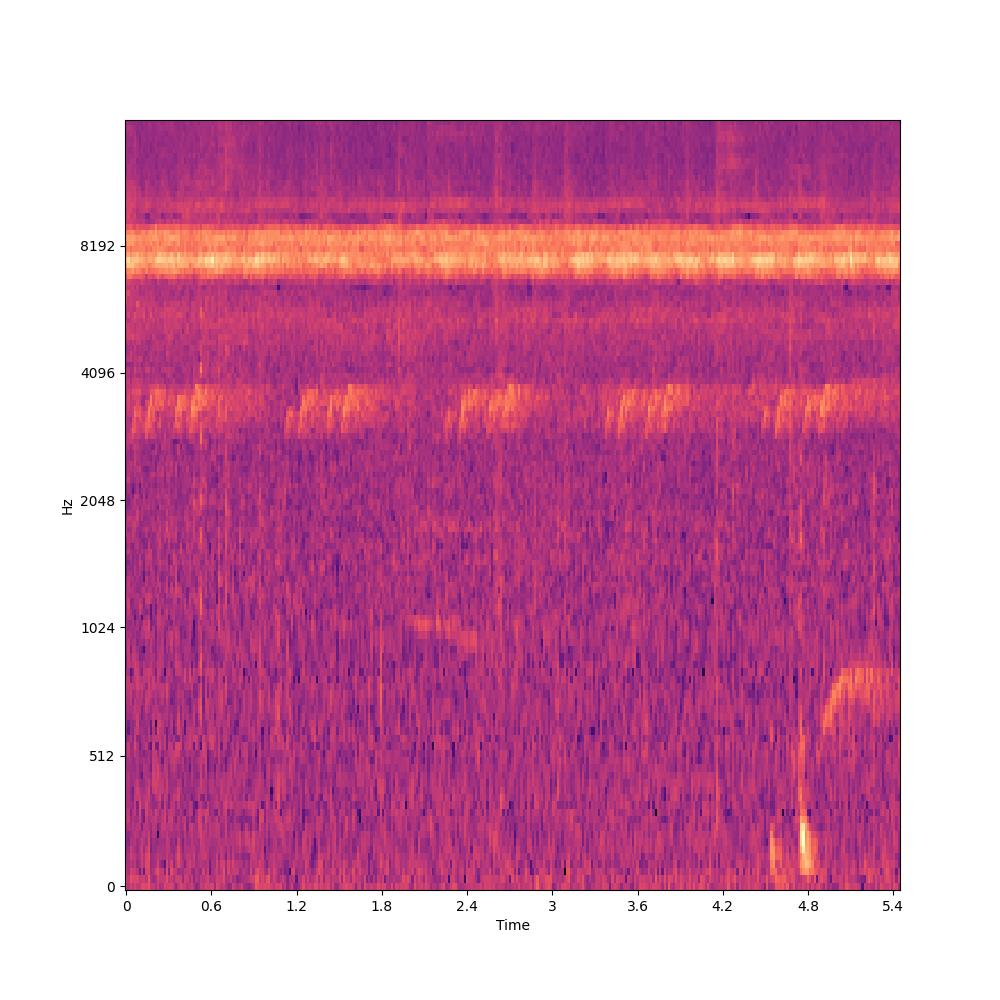

In [ ]:
from tqdm import tqdm
import supervision as sv

test_dataset = JSONLDataset(
    jsonl_file_path=f"/content/drive/MyDrive/kaggle/training_data_infer.jsonl",
    image_directory_path=f"{mel_plots_dir}",
)

CLASSES = example_submission_df.columns[1:].tolist()


TORCH_DTYPE = torch.bfloat16
image, label = test_dataset[5]
prefix = "<image>" + label["prefix"]
suffix = label["suffix"]

inputs = processor(
    text=prefix,
    images=image,
    return_tensors="pt"
).to(TORCH_DTYPE).to(device)

prefix_length = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    generation = generation[0][prefix_length:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(generation)
    print(decoded)

w, h = image.size
print(w,h)
detections = sv.Detections.from_lmm(
    lmm='paligemma',
    result=decoded,
    resolution_wh=(w, h),
    classes=CLASSES)

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator(smart_position=True).annotate(annotated_image, detections)
annotated_image

In [ ]:
print(suffix)
print(detections)
print(CLASSES)
print(test_dataset[5])

21211
Detections(xyxy=array([], shape=(0, 4), dtype=float64), mask=None, confidence=None, class_id=array([], dtype=float64), tracker_id=None, data={'class_name': array([], dtype='<U32')}, metadata={})
['1139490', '1192948', '1194042', '126247', '1346504', '134933', '135045', '1462711', '1462737', '1564122', '21038', '21116', '21211', '22333', '22973', '22976', '24272', '24292', '24322', '41663', '41778', '41970', '42007', '42087', '42113', '46010', '47067', '476537', '476538', '48124', '50186', '517119', '523060', '528041', '52884', '548639', '555086', '555142', '566513', '64862', '65336', '65344', '65349', '65373', '65419', '65448', '65547', '65962', '66016', '66531', '66578', '66893', '67082', '67252', '714022', '715170', '787625', '81930', '868458', '963335', 'amakin1', 'amekes', 'ampkin1', 'anhing', 'babwar', 'bafibi1', 'banana', 'baymac', 'bbwduc', 'bicwre1', 'bkcdon', 'bkmtou1', 'blbgra1', 'blbwre1', 'blcant4', 'blchaw1', 'blcjay1', 'blctit1', 'blhpar1', 'blkvul', 'bobfly1', 'bob

In [ ]:
print(prefix)
print()
print(suffix)

<image>detect 1139490 ; 1192948 ; 1194042 ; 126247 ; 1346504 ; 134933 ; 135045 ; 1462711 ; 1462737 ; 1564122 ; 21038 ; 21116 ; 21211 ; 22333 ; 22973 ; 22976 ; 24272 ; 24292 ; 24322 ; 41663 ; 41778 ; 41970 ; 42007 ; 42087 ; 42113 ; 46010 ; 47067 ; 476537 ; 476538 ; 48124 ; 50186 ; 517119 ; 523060 ; 528041 ; 52884 ; 548639 ; 555086 ; 555142 ; 566513 ; 64862 ; 65336 ; 65344 ; 65349 ; 65373 ; 65419 ; 65448 ; 65547 ; 65962 ; 66016 ; 66531 ; 66578 ; 66893 ; 67082 ; 67252 ; 714022 ; 715170 ; 787625 ; 81930 ; 868458 ; 963335 ; amakin1 ; amekes ; ampkin1 ; anhing ; babwar ; bafibi1 ; banana ; baymac ; bbwduc ; bicwre1 ; bkcdon ; bkmtou1 ; blbgra1 ; blbwre1 ; blcant4 ; blchaw1 ; blcjay1 ; blctit1 ; blhpar1 ; blkvul ; bobfly1 ; bobher1 ; brtpar1 ; bubcur1 ; bubwre1 ; bucmot3 ; bugtan ; butsal1 ; cargra1 ; cattyr ; chbant1 ; chfmac1 ; cinbec1 ; cocher1 ; cocwoo1 ; colara1 ; colcha1 ; compau ; compot1 ; cotfly1 ; crbtan1 ; crcwoo1 ; crebob1 ; cregua1 ; creoro1 ; eardov1 ; fotfly ; gohman1 ; grasal4

### Evaluate fine-tuned PaliGemma2 model

In [ ]:
import numpy as np
from tqdm import tqdm

images = []
targets = []
predictions = []

with torch.inference_mode():
    for i in tqdm(range(100,150)):
    # for i in tqdm(range(len(test_dataset))):
        image, label = test_dataset[i]
        prefix = "<image>" + label["prefix"]
        suffix = label["suffix"]

        inputs = processor(
            text=prefix,
            images=image,
            return_tensors="pt"
        ).to(TORCH_DTYPE).to(device)

        prefix_length = inputs["input_ids"].shape[-1]

        generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
        generation = generation[0][prefix_length:]
        generated_text = processor.decode(generation, skip_special_tokens=True)

        w, h = image.size
        prediction = sv.Detections.from_lmm(
            lmm='paligemma',
            result=generated_text,
            resolution_wh=(w, h),
            classes=CLASSES)

        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))

        target = sv.Detections.from_lmm(
            lmm='paligemma',
            result=suffix,
            resolution_wh=(w, h),
            classes=CLASSES)

        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

        images.append(image)
        targets.append(target)
        predictions.append(prediction)

100%|██████████| 2866/2866 [1:08:57<00:00,  1.44s/it]


In [ ]:
print(len(images))
print(len(targets))
print(predictions)
pred_df = pd.DataFrame(predictions)
pred_df.head()
print(prediction)

2866
2866
[Detections(xyxy=array([], shape=(0, 4), dtype=float64), mask=None, confidence=array([], dtype=float64), class_id=array([], dtype=float64), tracker_id=None, data={'class_name': array([], dtype='<U32')}, metadata={}), Detections(xyxy=array([], shape=(0, 4), dtype=float64), mask=None, confidence=array([], dtype=float64), class_id=array([], dtype=float64), tracker_id=None, data={'class_name': array([], dtype='<U32')}, metadata={}), Detections(xyxy=array([], shape=(0, 4), dtype=float64), mask=None, confidence=array([], dtype=float64), class_id=array([], dtype=float64), tracker_id=None, data={'class_name': array([], dtype='<U32')}, metadata={}), Detections(xyxy=array([], shape=(0, 4), dtype=float64), mask=None, confidence=array([], dtype=float64), class_id=array([], dtype=float64), tracker_id=None, data={'class_name': array([], dtype='<U32')}, metadata={}), Detections(xyxy=array([], shape=(0, 4), dtype=float64), mask=None, confidence=array([], dtype=float64), class_id=array([], dt

In [ ]:
# @title Calculate mAP

from supervision.metrics import MeanAveragePrecision, MetricTarget

# map_metric = MeanAveragePrecision(metric_target=MetricTarget.BOXES)
# map_metric = MeanAveragePrecision()
# del map_metric
map_result = map_metric.update(predictions, targets).compute()

print(map_result)

NameError: name 'map_metric' is not defined

In [ ]:
map_result.plot()

In [ ]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

In [ ]:
annotated_images = []

for i in range(25):
    image = images[i]
    detections = predictions[i]

    annotated_image = image.copy()
    annotated_image = sv.BoxAnnotator(thickness=4).annotate(annotated_image, detections)
    annotated_image = sv.LabelAnnotator(text_scale=2, text_thickness=4, smart_position=True).annotate(annotated_image, detections)
    annotated_images.append(annotated_image)

sv.plot_images_grid(annotated_images, (5, 5))